In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [146]:
df = pd.read_csv('Startdata.csv', delimiter=';')
print(df.head())

   Device_type            Timestamp Heart rate  Activity type Sleep stage  \
0  Apple Watch  20250602074248+0200         42              0       Awake   
1  Apple Watch  20250602074813+0200         58              1       Awake   
2  Apple Watch  20250602075146+0200         60              1       Awake   
3  Apple Watch  20250602075658+0200         75              0       Awake   
4  Apple Watch  20250602080402+0200         84              0       Awake   

   Caffeine  
0       0.0  
1       0.0  
2       0.0  
3       NaN  
4       NaN  


## Part 2 EDA

In [147]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%Y%m%d%H%M%S%z", errors="coerce")
df["Heart rate"] = pd.to_numeric(df["Heart rate"], errors="coerce")

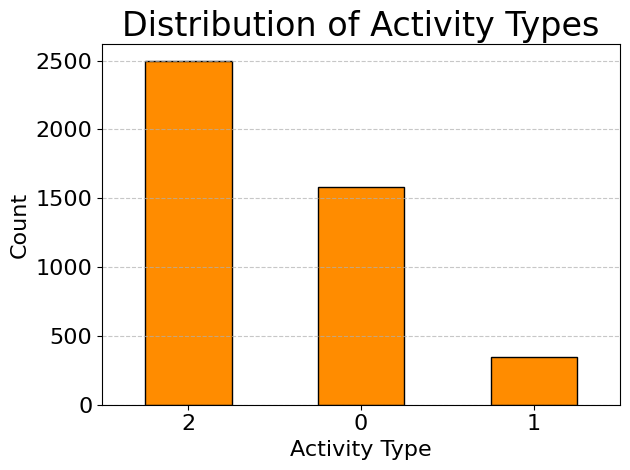

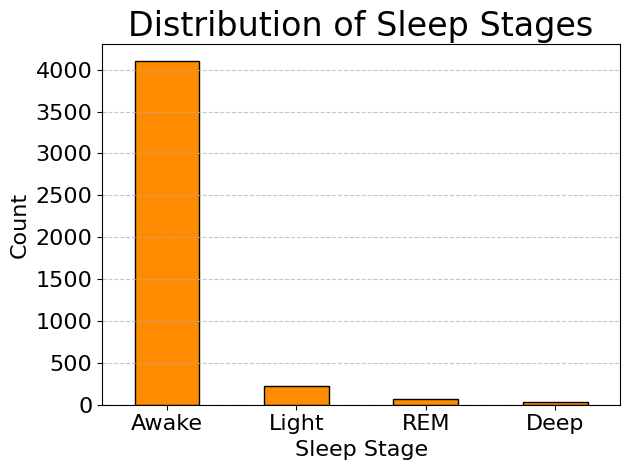

In [148]:

#Activity type
activity_counts = df["Activity type"].value_counts(dropna=False)
activity_counts.index = activity_counts.index.fillna("Missing")
activity_counts.plot(kind='bar', color='darkorange', edgecolor='black')
plt.xlabel("Activity Type", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Distribution of Activity Types", fontsize=24)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("/Users/dora/Desktop/activity_type.png", dpi=300)
plt.show()

#Sleep stage
activity_counts = df["Sleep stage"].value_counts(dropna=False)
activity_counts.index = activity_counts.index.fillna("Missing")
activity_counts.plot(kind='bar', color='darkorange', edgecolor='black')
plt.xlabel("Sleep Stage", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Distribution of Sleep Stages", fontsize=24)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("/Users/dora/Desktop/sleep_stage.png", dpi=300)
plt.show()



In [149]:
#Creating various intervals
def resample_df(df, interval="10min"):
    """
    Resample numerical and categorical columns in a time-indexed DataFrame.

    Parameters:
        df (pd.DataFrame): Input dataframe with a 'Timestamp' column.
        interval (str): Time interval string for resampling (e.g., '10min', '1H').

    Returns:
        pd.DataFrame: Resampled dataframe with 'Timestamp' as a column.
    """
    # Ensure Timestamp is parsed and set as index
    df = df.copy()
    df.columns = df.columns.str.strip()
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
    df["Heart rate"] = pd.to_numeric(df["Heart rate"], errors="coerce")
    df = df.set_index("Timestamp").sort_index()

    # Define columns
    numerical_cols = ["Heart rate"]
    categorical_cols = ["Activity type", "Sleep stage", "Caffeine"]

    # Convert categoricals to string to avoid numeric aggregation
    for col in categorical_cols:
        df[col] = df[col].astype(str)

    # Resample numericals using mean
    numerical_resampled = df[numerical_cols].resample(interval).mean()

    # Resample categoricals using mode
    categorical_resampled = pd.DataFrame(index=numerical_resampled.index)
    for col in categorical_cols:
        categorical_resampled[col] = df[col].resample(interval).agg(
            lambda x: x.mode().iloc[0] if not x.mode().empty else None
        )

    # Combine and reset index
    df_resampled = pd.concat([numerical_resampled, categorical_resampled], axis=1).reset_index()

    return df_resampled

df_10min = resample_df(df, "10min")
df_5min = resample_df(df, "5min")
df_15min = resample_df(df, "15min")

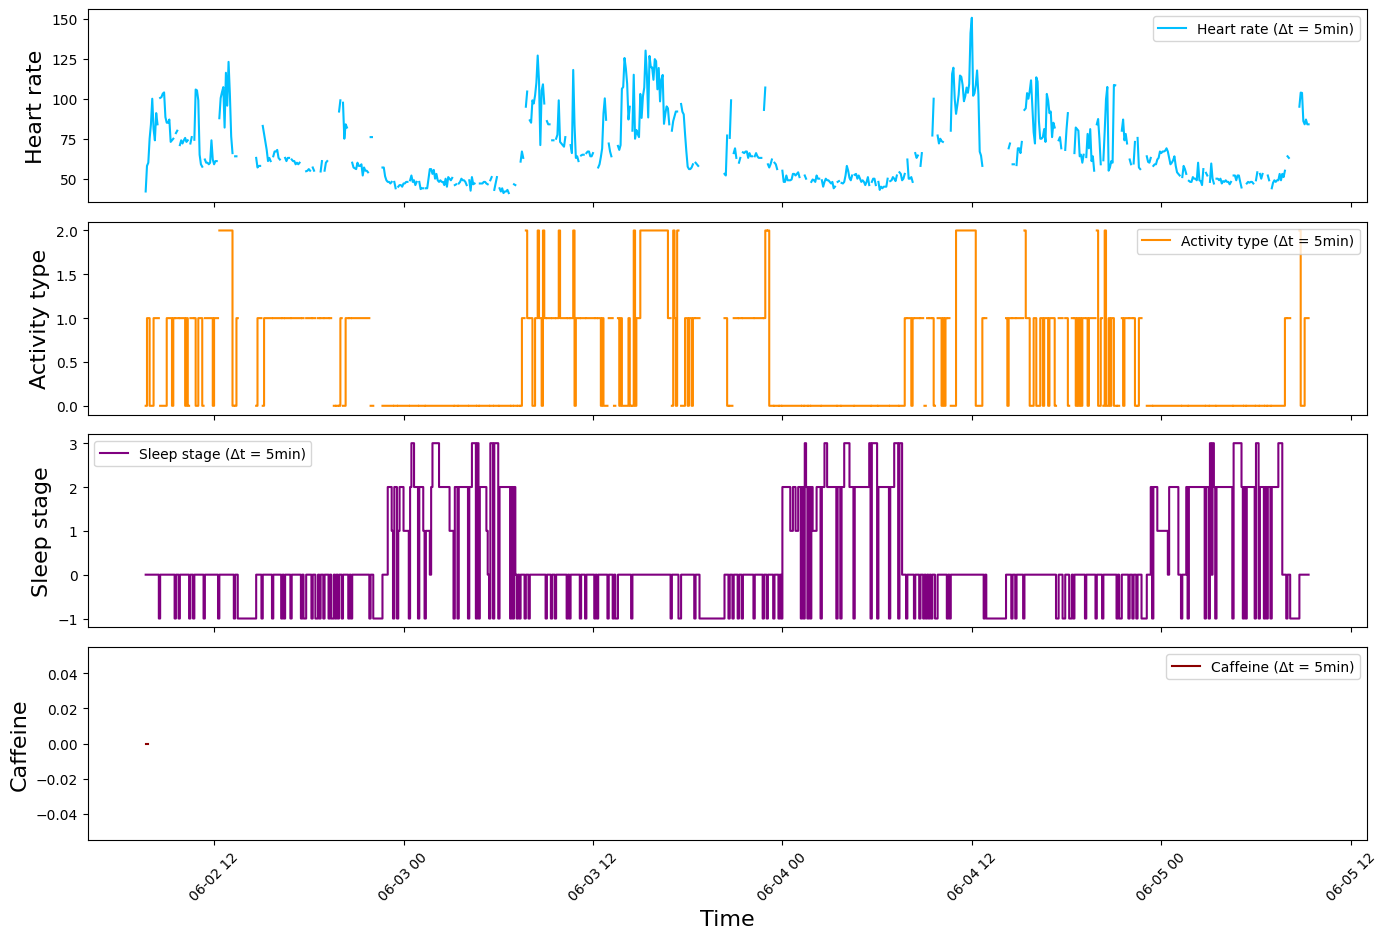

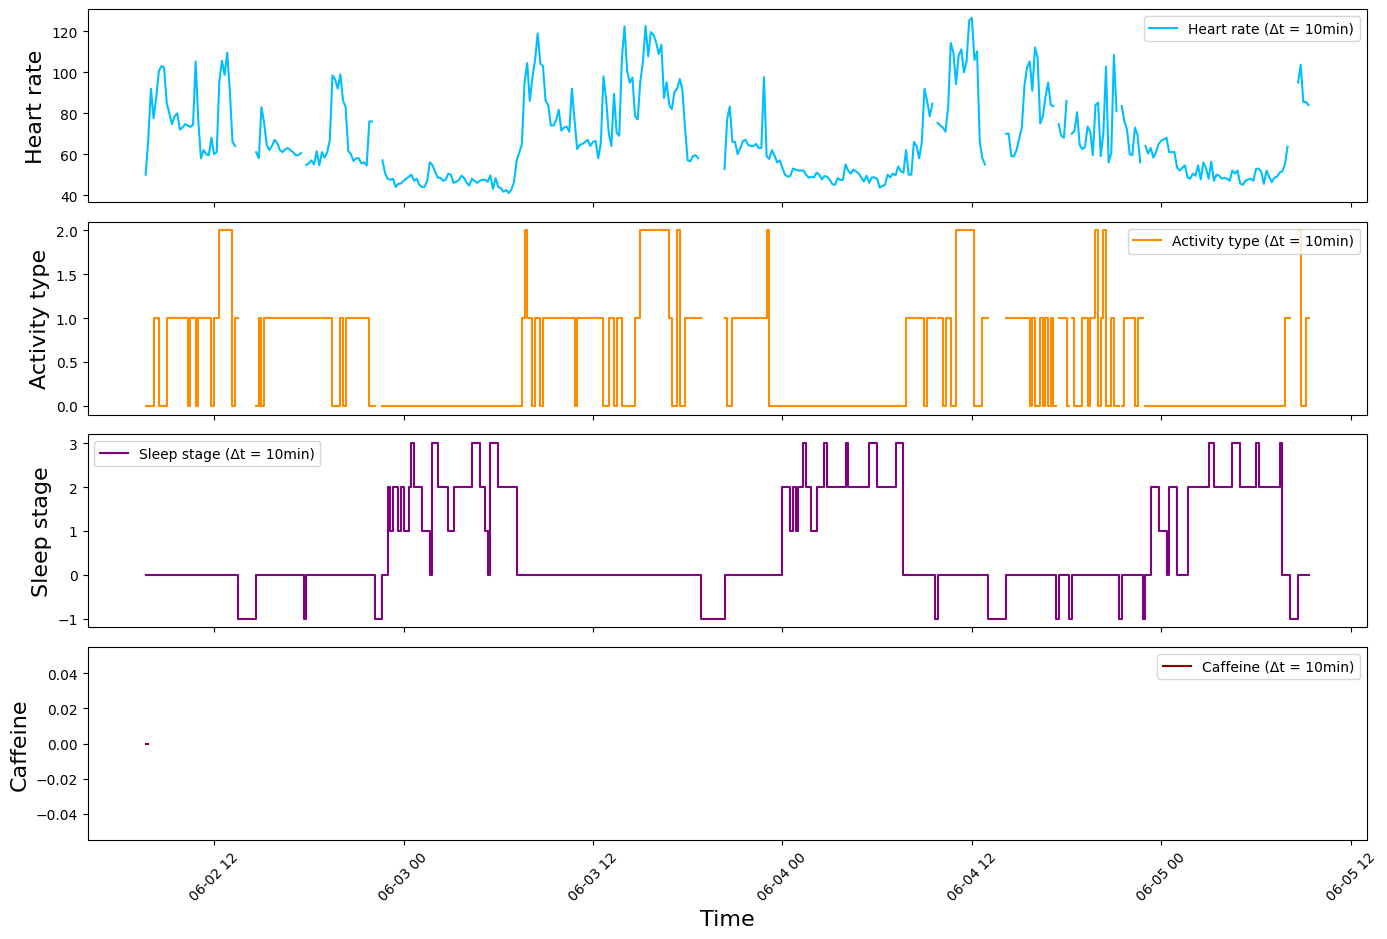

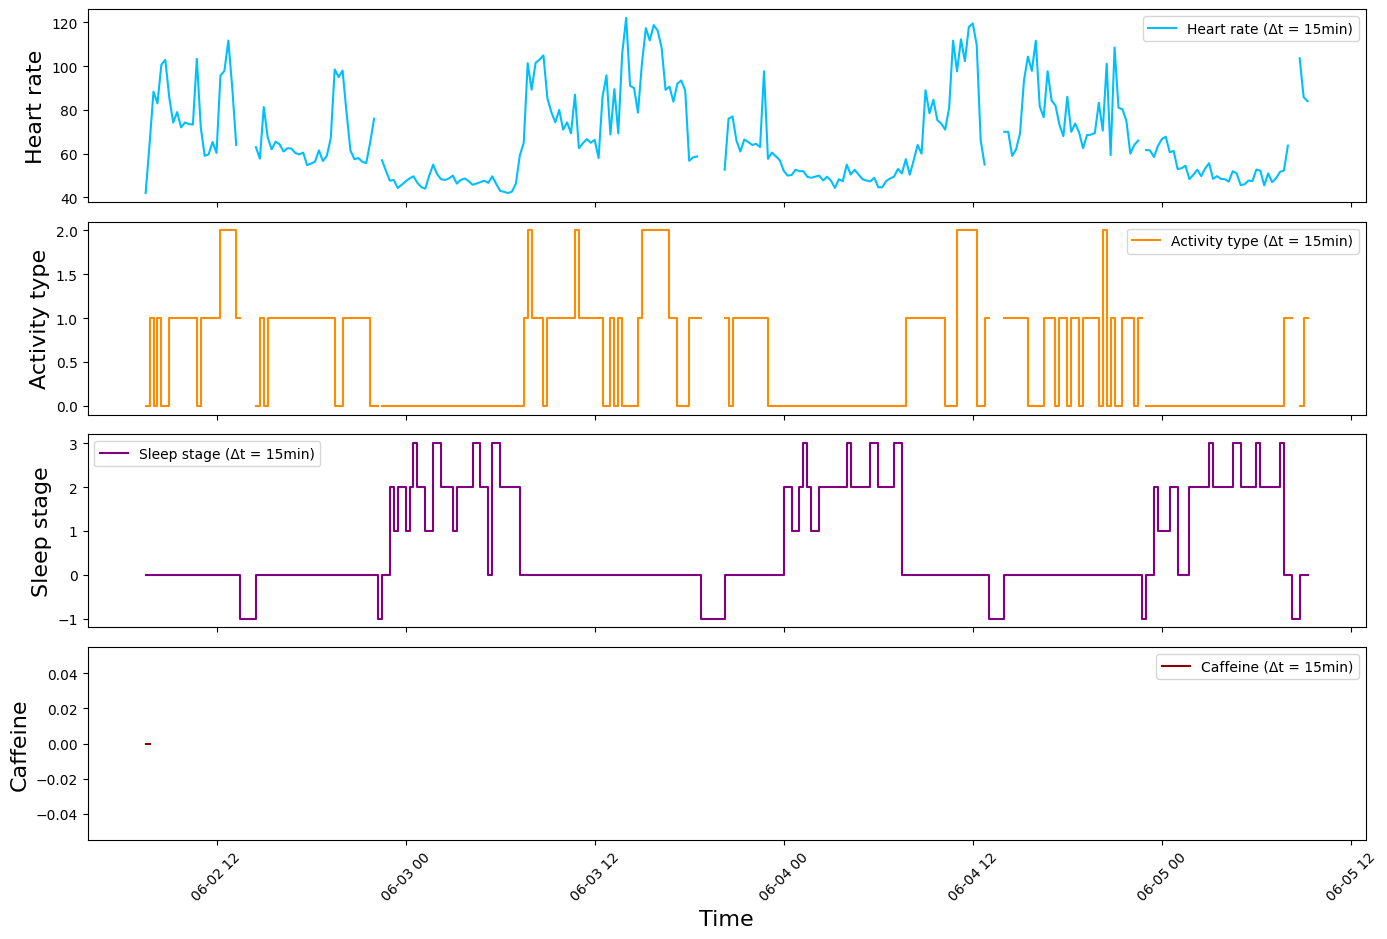

In [151]:
def plot_sensor_overview(df_resampled, interval_label="10min", save_path="/Users/dora/Desktop/timeseries_plot.png"):
    """
    Plots 4 sensor/categorical measurements over time in subplots.
    
    Parameters:
        df_resampled (pd.DataFrame): Resampled dataframe with 'Timestamp' as a column.
        interval_label (str): Label for the time interval (e.g., '10min') to show in the title and legends.
        save_path (str): File path to save the resulting plot image.
    """

    # Ensure timestamp is in datetime format and set as index
    df_resampled = df_resampled.copy()
    df_resampled["Timestamp"] = pd.to_datetime(df_resampled["Timestamp"], errors="coerce")
    df_resampled = df_resampled.set_index("Timestamp")

    # Clean caffeine column
    df_resampled["Caffeine"] = pd.to_numeric(df_resampled["Caffeine"], errors="coerce")

    # Set up figure and axes
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(14, 10), sharex=True)

    # Plot 1: Heart rate
    axs[0].plot(df_resampled.index,
                df_resampled["Heart rate"],
                label=f"Heart rate (Δt = {interval_label})",
                color='deepskyblue')
    axs[0].set_ylabel("Heart rate", fontsize=16)
    axs[0].legend()

    # Plot 2: Activity type
    axs[1].plot(df_resampled.index,
                pd.to_numeric(df_resampled["Activity type"], errors='coerce'),
                drawstyle='steps-post',
                label=f"Activity type (Δt = {interval_label})",
                color='darkorange')
    axs[1].set_ylabel("Activity type", fontsize=16)
    axs[1].legend()

    # Plot 3: Sleep stage
    axs[2].plot(df_resampled.index,
                df_resampled["Sleep stage"].astype("category").cat.codes,
                drawstyle='steps-post',
                label=f"Sleep stage (Δt = {interval_label})",
                color='purple')
    axs[2].set_ylabel("Sleep stage", fontsize=16)
    axs[2].legend()

    # Plot 4: Caffeine
    axs[3].plot(df_resampled.index,
                df_resampled["Caffeine"],
                label=f"Caffeine (Δt = {interval_label})",
                color='darkred')
    axs[3].set_ylabel("Caffeine", fontsize=16)
    axs[3].legend()

    # Final formatting
    axs[-1].set_xlabel("Time", fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leaves space for suptitle
    plt.savefig(save_path, dpi=300)
    plt.show()

plot_sensor_overview(df_5min, interval_label="5min", save_path="/Users/dora/Desktop/5.png")
plot_sensor_overview(df_10min, interval_label="10min", save_path="/Users/dora/Desktop/10.png")
plot_sensor_overview(df_15min, interval_label="15min", save_path="/Users/dora/Desktop/15.png")

In [154]:
#For further anlysis we use df_10min
print(df_10min.isna().sum())

Timestamp         0
Heart rate       35
Activity type    35
Sleep stage      35
Caffeine         35
dtype: int64
